          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

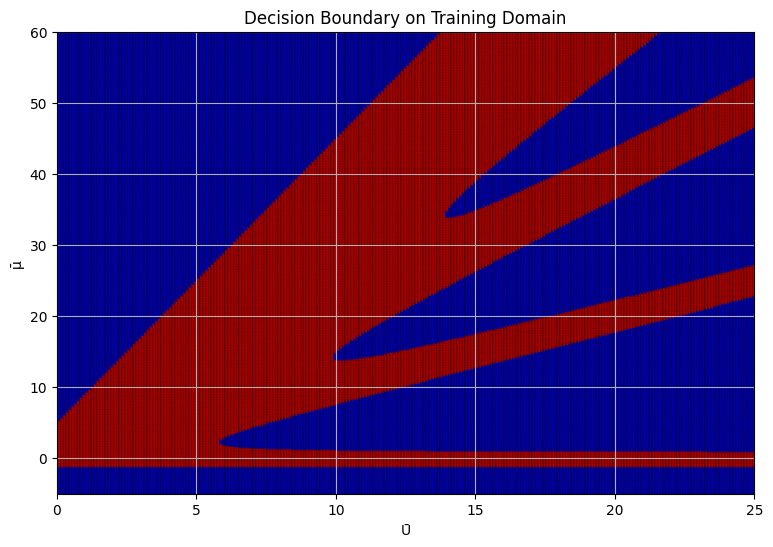

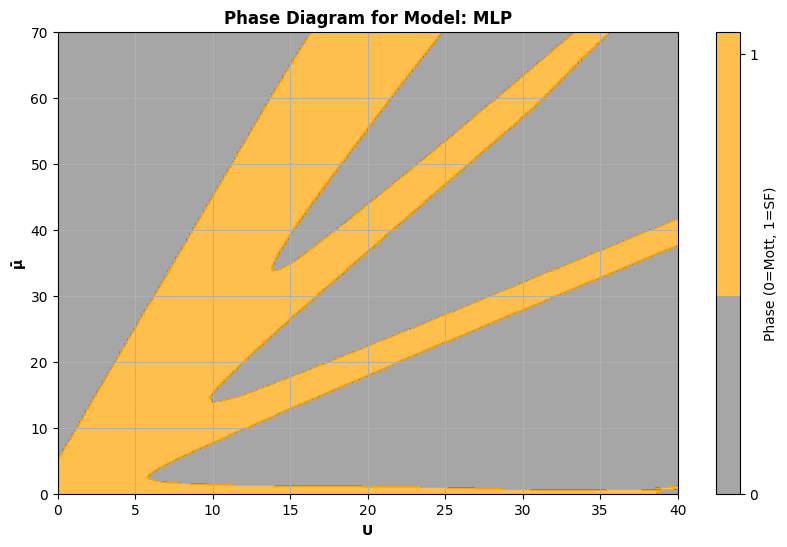


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [59]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid
        
# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# # Features and targets
# X = df[["Ubar","Mubar"]].values.astype(np.float32)
# y = {
#     "phase": df["Phase"].values.astype(np.float32),
#     "phi2": df["Phi2"].values.astype(np.float32),
#     "rho": df["Density"].values.astype(np.float32),
# }
# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# # ------------------------------
# # Smart sampling strategy
# # ------------------------------
# # n_MI = min(2000, len(df_MI))             # cap deep MI
# # n_SF = min(2000, len(df_SF))             # cap deep SF
# # n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(15000, len(df_MI))
# n_SF = min(15000, len(df_SF))
# n_boundary = min(30000, len(df_boundary))

# # n_MI = min(3000, len(df_MI))
# # n_SF = min(3000, len(df_SF))
# # n_boundary = min(6000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)
        
# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------

mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])


models = {
    "MLP": mlp
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))


for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    # ---------- 4) Plot decision boundary on training domain ----------
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 40.0   # extend beyond training range
    mu_min, mu_max = 0.0, 70.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    # plt.xlabel("Ū")
    # plt.ylabel("μ̄")
    plt.xlabel("U",fontsize=10,fontweight="bold")
    plt.ylabel("μ̄",fontsize=10, fontweight="bold")
    plt.title(f"Phase Diagram for Model: {i}",fontsize=12, fontweight="bold")
    plt.savefig('Full-MLP', dpi=300, bbox_inches='tight')
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


In [64]:
# ---------- 1) Actual Boundary Table ----------
boundary_points_true = []
grouped = df.groupby("Ubar")
for U, group in grouped:
    group_sorted = group.sort_values("Mubar")
    phase_vals = group_sorted["Phase"].values
    mu_vals_sorted = group_sorted["Mubar"].values
    transitions = np.where(np.diff(phase_vals) != 0)[0]
    for t in transitions:
        mu_b = (mu_vals_sorted[t] + mu_vals_sorted[t + 1]) / 2
        boundary_points_true.append((U, mu_b))

actual_boundary_df = pd.DataFrame(boundary_points_true, columns=["Ubar", "Mubar"])
actual_boundary_df["Type"] = "Actual"

# Add phases
actual_phase_list = []
pred_phase_list = []

for idx, row in actual_boundary_df.iterrows():
    U = row["Ubar"]
    mu = row["Mubar"]

    # Actual phase from dataset (nearest neighbor)
    nearest = df.iloc[((df["Ubar"] - U)**2 + (df["Mubar"] - mu)**2).argmin()]
    actual_phase_list.append(nearest["Phase"])

    # Predicted phase from phase_map
    i = np.abs(U_vals - U).argmin()
    j = np.abs(mu_vals - mu).argmin()
    pred_phase_list.append(phase_map[j, i])

actual_boundary_df["Actual_Phase"] = actual_phase_list
actual_boundary_df["Predicted_Phase"] = pred_phase_list

# Save
actual_boundary_df.to_csv("actual_boundary_points.csv", index=False)
print("✅ Actual boundary points table saved.")
print(actual_boundary_df.head(10))


# ---------- 2) Predicted Boundary Table ----------
boundary_pred_points = []
for idx, U in enumerate(U_vals):
    phase_col = phase_map[:, idx]
    transitions = np.where(np.diff(phase_col) != 0)[0]
    for t in transitions:
        mu_b = (mu_vals[t] + mu_vals[t + 1]) / 2
        boundary_pred_points.append((U, mu_b))

predicted_boundary_df = pd.DataFrame(boundary_pred_points, columns=["Ubar", "Mubar"])
predicted_boundary_df["Type"] = "Predicted"

# Add phases
actual_phase_list_pred = []
pred_phase_list_pred = []

for idx, row in predicted_boundary_df.iterrows():
    U = row["Ubar"]
    mu = row["Mubar"]

    # Actual phase from dataset (nearest neighbor)
    nearest = df.iloc[((df["Ubar"] - U)**2 + (df["Mubar"] - mu)**2).argmin()]
    actual_phase_list_pred.append(nearest["Phase"])

    # Predicted phase from phase_map
    i = np.abs(U_vals - U).argmin()
    j = np.abs(mu_vals - mu).argmin()
    pred_phase_list_pred.append(phase_map[j, i])

predicted_boundary_df["Actual_Phase"] = actual_phase_list_pred
predicted_boundary_df["Predicted_Phase"] = pred_phase_list_pred

# Save
predicted_boundary_df.to_csv("predicted_boundary_points.csv", index=False)
print("✅ Predicted boundary points table saved.")
print(predicted_boundary_df.head(10))


✅ Actual boundary points table saved.
   Ubar  Mubar    Type  Actual_Phase  Predicted_Phase
0   0.0  -1.05  Actual           0.0                1
1   0.0   5.05  Actual           1.0                1
2   0.1  -1.05  Actual           0.0                1
3   0.1   5.45  Actual           1.0                1
4   0.2  -1.05  Actual           0.0                1
5   0.2   5.85  Actual           1.0                1
6   0.3  -1.05  Actual           0.0                1
7   0.3   6.25  Actual           1.0                1
8   0.4  -1.05  Actual           0.0                1
9   0.4   6.65  Actual           1.0                1
✅ Predicted boundary points table saved.
   Ubar  Mubar       Type  Actual_Phase  Predicted_Phase
0   0.0   5.15  Predicted           0.0                1
1   0.1   5.55  Predicted           0.0                0
2   0.2   5.95  Predicted           0.0                1
3   0.3   6.35  Predicted           0.0                1
4   0.4   6.75  Predicted           0.0   

In [65]:
# U values we are interested in
U_targets = [10, 15, 20, 25]

# Filter Actual boundaries
actual_boundary_selected = actual_boundary_df[actual_boundary_df["Ubar"].isin(U_targets)].sort_values(["Ubar", "Mubar"])
print("✅ Actual Boundary Points for U = 10, 15, 20, 25")
print(actual_boundary_selected)

# Filter Predicted boundaries
predicted_boundary_selected = predicted_boundary_df[predicted_boundary_df["Ubar"].isin(U_targets)].sort_values(["Ubar", "Mubar"])
print("\n✅ Predicted Boundary Points for U = 10, 15, 20, 25")
print(predicted_boundary_selected)

# Optionally, save these filtered tables
actual_boundary_selected.to_csv("actual_boundary_U10_15_20_25.csv", index=False)
predicted_boundary_selected.to_csv("predicted_boundary_U10_15_20_25.csv", index=False)


✅ Actual Boundary Points for U = 10, 15, 20, 25
      Ubar  Mubar    Type  Actual_Phase  Predicted_Phase
282   10.0  -1.05  Actual           0.0                1
283   10.0   1.35  Actual           1.0                0
284   10.0   7.65  Actual           0.0                0
285   10.0  14.05  Actual           0.0                0
286   10.0  14.95  Actual           0.0                0
287   10.0  45.05  Actual           1.0                1
590   15.0  -1.05  Actual           0.0                1
591   15.0   1.15  Actual           0.0                0
592   15.0  12.85  Actual           0.0                0
593   15.0  17.65  Actual           1.0                0
594   15.0  26.35  Actual           1.0                0
595   15.0  35.05  Actual           1.0                0
596   15.0  38.95  Actual           0.0                0
940   20.0  -1.05  Actual           0.0                1
941   20.0   1.15  Actual           0.0                0
942   20.0  17.85  Actual           0.0 

In [63]:
U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
phase_map = pred_ext.reshape(U_grid.shape)
# ---------- Extract Predicted Boundary ----------
boundary_points_pred = []

for i, U in enumerate(U_vals):
    phase_column = phase_map[:, i]
    transitions = np.where(np.diff(phase_column) != 0)[0]  # where phase changes
    for t in transitions:
        mu_boundary = (mu_vals[t] + mu_vals[t+1]) / 2
        boundary_points_pred.append((U, mu_boundary))

boundary_pred_df = pd.DataFrame(boundary_points_pred, columns=["Ubar", "Mubar"])

# ---------- Extract Actual Boundary from Data ----------
boundary_points_true = []
grouped = df.groupby("Ubar")

for U, group in grouped:
    group_sorted = group.sort_values("Mubar")
    phase_vals = group_sorted["Phase"].values
    mu_vals_sorted = group_sorted["Mubar"].values
    transitions = np.where(np.diff(phase_vals) != 0)[0]
    for t in transitions:
        mu_boundary = (mu_vals_sorted[t] + mu_vals_sorted[t+1]) / 2
        boundary_points_true.append((U, mu_boundary))

boundary_true_df = pd.DataFrame(boundary_points_true, columns=["Ubar", "Mubar"])
# ---------- Compare Boundaries ----------
U_common = sorted(set(boundary_true_df["Ubar"]) & set(boundary_pred_df["Ubar"]))
comparison = []

for U in U_common:
    mu_true = boundary_true_df.loc[boundary_true_df["Ubar"] == U, "Mubar"].mean()
    mu_pred = boundary_pred_df.loc[boundary_pred_df["Ubar"] == U, "Mubar"].mean()
    diff = abs(mu_true - mu_pred)
    comparison.append((U, mu_true, mu_pred, diff))

boundary_comparison = pd.DataFrame(comparison, columns=["Ubar", "Mu_true", "Mu_pred", "Abs_Diff"])
print("\nBoundary Comparison Table:")
print(boundary_comparison)
# ---------- Extract Specific U boundaries ----------
U_targets = [10, 15, 20, 25]
tol = 0.05  # tolerance for rounding

selected_boundaries = boundary_comparison[
    boundary_comparison["Ubar"].apply(lambda u: any(abs(u - t) <= tol for t in U_targets))
]

print("\nSelected U boundaries:")
print(selected_boundaries)




Boundary Comparison Table:
     Ubar    Mu_true    Mu_pred  Abs_Diff
0     0.0   2.000000   5.150000      3.15
1     0.1   2.200000   5.550000      3.35
2     0.2   2.400000   5.950000      3.55
3     0.4   2.800000   6.750000      3.95
4     0.5   3.000000   7.150000      4.15
..    ...        ...        ...       ...
199  24.5  24.616667  36.266667     11.65
200  24.6  24.716667  36.416667     11.70
201  24.7  24.816667  36.566667     11.75
202  24.8  24.916667  36.716667     11.80
203  25.0  25.100000  30.290000      5.19

[204 rows x 4 columns]

Selected U boundaries:
     Ubar    Mu_true    Mu_pred  Abs_Diff
91   10.0  13.666667  16.630000  2.963333
121  15.0  18.707143  28.192857  9.485714
163  20.0  25.135714  29.550000  4.414286
203  25.0  25.100000  30.290000  5.190000


In [66]:
# Filter out negative μ in actual boundaries
actual_boundary_pos = actual_boundary_selected[actual_boundary_selected["Mubar"] >= 0].copy()
predicted_boundary_pos = predicted_boundary_selected[predicted_boundary_selected["Mubar"] >= 0].copy()

comparison_rows = []

for U in U_targets:
    mu_actual = actual_boundary_pos[actual_boundary_pos["Ubar"] == U]["Mubar"].values
    mu_pred = predicted_boundary_pos[predicted_boundary_pos["Ubar"] == U]["Mubar"].values
    
    # Sort both arrays for one-to-one comparison
    mu_actual_sorted = np.sort(mu_actual)
    mu_pred_sorted = np.sort(mu_pred)
    
    # Ensure same number of points for U
    n_points = min(len(mu_actual_sorted), len(mu_pred_sorted))
    
    for i in range(n_points):
        mu_a = mu_actual_sorted[i]
        mu_p = mu_pred_sorted[i]
        
        actual_phase = actual_boundary_pos[(actual_boundary_pos["Ubar"]==U) & (actual_boundary_pos["Mubar"]==mu_a)]["Actual_Phase"].values[0]
        predicted_phase = predicted_boundary_pos[(predicted_boundary_pos["Ubar"]==U) & (predicted_boundary_pos["Mubar"]==mu_p)]["Predicted_Phase"].values[0]
        
        comparison_rows.append([U, mu_a, mu_p, actual_phase, predicted_phase, mu_a - mu_p])

comparison_df = pd.DataFrame(comparison_rows, columns=["Ubar", "Actual_Mu", "Predicted_Mu", "Actual_Phase", "Predicted_Phase", "Delta_Mu"])
comparison_df = comparison_df.sort_values(["Ubar", "Actual_Mu"])
comparison_df.to_csv("boundary_mu_comparison_aligned.csv", index=False)

print("✅ Aligned comparison table saved (negative μ ignored).")
print(comparison_df)


✅ Aligned comparison table saved (negative μ ignored).
    Ubar  Actual_Mu  Predicted_Mu  Actual_Phase  Predicted_Phase      Delta_Mu
0     10       1.35          1.35           1.0                1  4.440892e-16
1     10       7.65          7.75           0.0                0 -1.000000e-01
2     10      14.05         13.85           0.0                0  2.000000e-01
3     10      14.95         15.15           0.0                1 -2.000000e-01
4     10      45.05         45.05           1.0                1  0.000000e+00
5     15       1.15          1.15           0.0                1  2.220446e-16
6     15      12.85         12.95           0.0                0 -1.000000e-01
7     15      17.65         17.65           1.0                1  3.552714e-15
8     15      26.35         26.55           1.0                0 -2.000000e-01
9     15      35.05         34.85           1.0                1  2.000000e-01
10    15      38.95         39.25           0.0                0 -3.000000e-

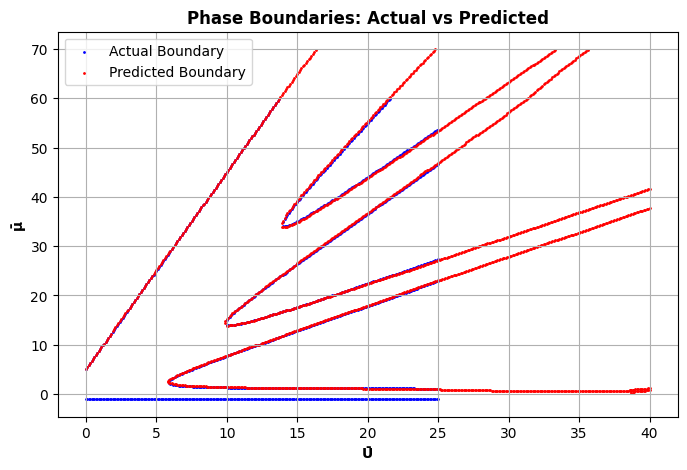

In [58]:
plt.figure(figsize=(8,5))
plt.scatter(boundary_true_df["Ubar"], boundary_true_df["Mubar"], color='blue', s=1, label='Actual Boundary')
plt.scatter(boundary_pred_df["Ubar"], boundary_pred_df["Mubar"], color='red', s=1, label='Predicted Boundary')
plt.xlabel("Ū", fontsize=10, fontweight="bold")
plt.ylabel("μ̄", fontsize=10, fontweight="bold")
plt.title("Phase Boundaries: Actual vs Predicted", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# ---------- 7) Compare Predictions with Actual Data for fixed U values ----------
U_targets = [10, 15, 20, 25]

comparison_tables = {}

for U_fixed in U_targets:
    # Extract predicted data for this U
    mask_pred = np.isclose(grid_ext["Ubar"], U_fixed, atol=1e-3)
    pred_subset = grid_ext[mask_pred].copy()
    pred_subset["Predicted_Phase"] = clf.predict(pred_subset)
    
    # Extract actual data for this U from the dataset (rounded match)
    df_actual = df.copy()
    df_actual["Ubar_r"] = df_actual["Ubar"].round(1)
    df_actual["Mubar_r"] = df_actual["Mubar"].round(1)
    
    actual_subset = df_actual[df_actual["Ubar_r"] == round(U_fixed, 1)][["Mubar_r", "Phase"]].rename(
        columns={"Phase": "Actual_Phase"}
    )
    
    # Round predicted μ values to same grid for merging
    pred_subset["Mubar_r"] = pred_subset["Mubar"].round(1)
    pred_subset = pred_subset[["Mubar_r", "Predicted_Phase"]]
    
    # Merge predicted and actual
    merged = pd.merge(actual_subset, pred_subset, on="Mubar_r", how="inner").sort_values(by="Mubar_r")
    
    comparison_tables[U_fixed] = merged
    
    print(f"\n🧩 Comparison Table for U = {U_fixed}")
    print(merged.head(15))  # show first 15 rows for preview

# Optional: Combine into one dataframe for saving
df_all_comparisons = pd.concat(
    [t.assign(Ubar=U) for U, t in comparison_tables.items()],
    ignore_index=True
)

# Save for inspection
df_all_comparisons.to_csv("U_fixed_phase_comparison.csv", index=False)
print("\n✅ Saved full comparison table to 'U_fixed_phase_comparison.csv'")



🧩 Comparison Table for U = 10
    Mubar_r  Actual_Phase  Predicted_Phase
0       0.0             1                1
1       0.1             1                1
2       0.2             1                1
3       0.3             1                1
4       0.4             1                1
5       0.5             1                1
6       0.6             1                1
7       0.7             1                1
8       0.8             1                1
9       0.9             1                1
10      1.0             1                1
11      1.1             1                1
12      1.2             1                1
13      1.3             1                1
14      1.4             0                0

🧩 Comparison Table for U = 15
    Mubar_r  Actual_Phase  Predicted_Phase
0       0.0             1                1
1       0.1             1                1
2       0.2             1                1
3       0.3             1                1
4       0.4             1          

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\numeric.py:457: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


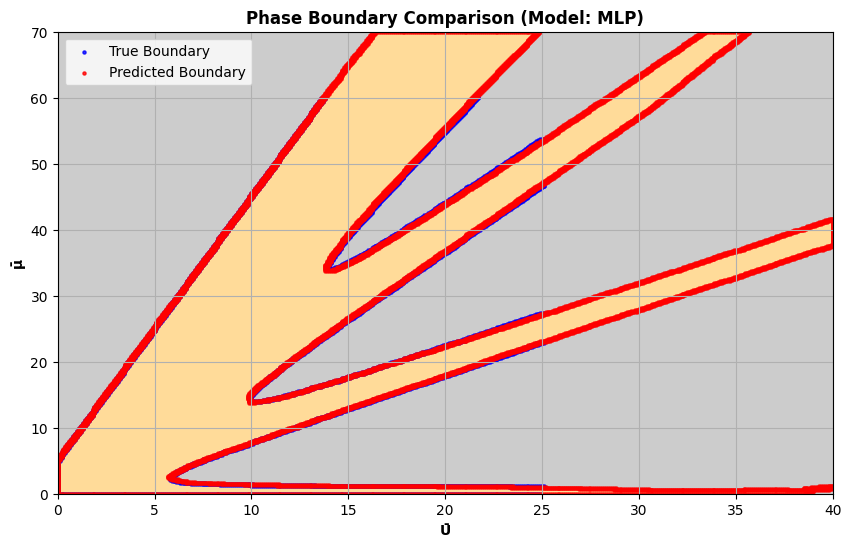


🔍 Boundary overlap (Jaccard similarity): 0.4370


In [13]:
    # ---------- 7) Extract & Compare Phase Boundaries ----------
    from scipy import ndimage

    # --- (a) Predicted phase map ---
    # phase_map has shape (len(mu_vals), len(U_vals))
    # Compute gradient magnitude
    grad_pred = np.sqrt(
        ndimage.sobel(phase_map, axis=0, mode='constant')**2 +
        ndimage.sobel(phase_map, axis=1, mode='constant')**2
    )

    # Mark where gradient is strong (i.e., near phase boundary)
    boundary_pred_mask = grad_pred > 0
    boundary_pred_y, boundary_pred_x = np.where(boundary_pred_mask)
    boundary_pred_U = U_grid[boundary_pred_y, boundary_pred_x]
    boundary_pred_mu = mu_grid[boundary_pred_y, boundary_pred_x]

    # --- (b) True (actual) phase map from dataset ---
    # Build ground truth on same grid
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int)
    phase_true_map = np.full_like(phase_map, np.nan)

    for iU, Uv in enumerate(U_vals):
        for jMu, Mv in enumerate(mu_vals):
            key = (round(Uv, 1), round(Mv, 1))
            if key in lookup.index:
                phase_true_map[jMu, iU] = lookup[key]

    # Gradient on the true map
    grad_true = np.sqrt(
        ndimage.sobel(np.nan_to_num(phase_true_map, nan=0), axis=0, mode='constant')**2 +
        ndimage.sobel(np.nan_to_num(phase_true_map, nan=0), axis=1, mode='constant')**2
    )

    boundary_true_mask = grad_true > 0
    boundary_true_y, boundary_true_x = np.where(boundary_true_mask)
    boundary_true_U = U_grid[boundary_true_y, boundary_true_x]
    boundary_true_mu = mu_grid[boundary_true_y, boundary_true_x]

    # ---------- 8) Plot Predicted vs True Boundaries ----------
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.4)
    plt.scatter(boundary_true_U, boundary_true_mu, s=5, color='blue', label='True Boundary', alpha=0.8)
    plt.scatter(boundary_pred_U, boundary_pred_mu, s=5, color='red', label='Predicted Boundary', alpha=0.8)
    plt.xlabel("Ū", fontsize=10, fontweight="bold")
    plt.ylabel("μ̄", fontsize=10, fontweight="bold")
    plt.title(f"Phase Boundary Comparison (Model: {i})", fontsize=12, fontweight="bold")
    plt.legend(frameon=True)
    plt.grid(True)
    plt.show()

    # ---------- 9) (Optional) Quantitative overlap metric ----------
    # Compute Jaccard similarity (intersection / union) between true and predicted boundaries
    overlap = np.logical_and(boundary_true_mask, boundary_pred_mask)
    union = np.logical_or(boundary_true_mask, boundary_pred_mask)
    jaccard = np.sum(overlap) / np.sum(union)
    print(f"\n🔍 Boundary overlap (Jaccard similarity): {jaccard:.4f}")


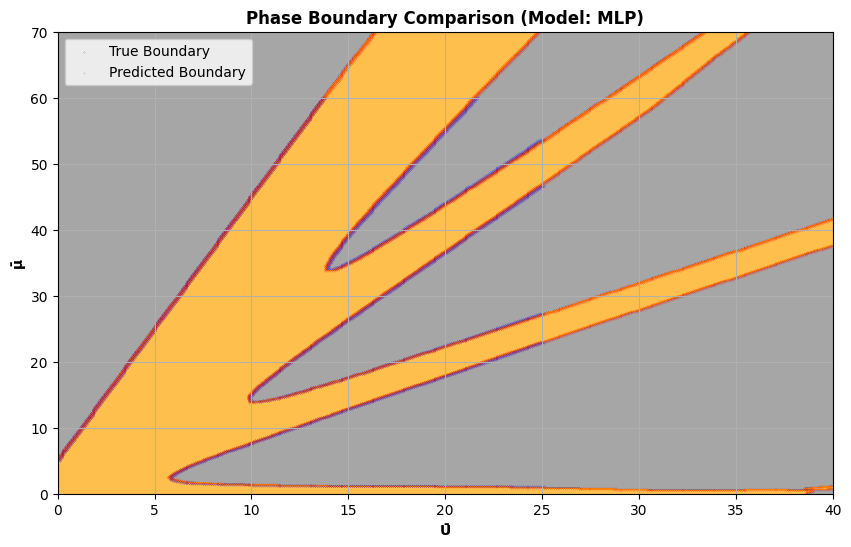

In [53]:
# --- Sharpen Predicted Phase Boundary ---
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Compute gradient
grad_pred = np.sqrt(
    ndimage.sobel(phase_map, axis=0, mode='reflect')**2 +
    ndimage.sobel(phase_map, axis=1, mode='reflect')**2
)

# Normalize gradient
grad_pred_norm = grad_pred / np.nanmax(grad_pred)

# Set adaptive threshold — higher = thinner line
threshold = 0.2  
boundary_pred_mask = grad_pred_norm > threshold

boundary_pred_y, boundary_pred_x = np.where(boundary_pred_mask)
boundary_pred_U = U_grid[boundary_pred_y, boundary_pred_x]
boundary_pred_mu = mu_grid[boundary_pred_y, boundary_pred_x]

# --- True boundary (unchanged) ---
grad_true = np.sqrt(
    ndimage.sobel(np.nan_to_num(phase_true_map, nan=0), axis=0, mode='reflect')**2 +
    ndimage.sobel(np.nan_to_num(phase_true_map, nan=0), axis=1, mode='reflect')**2
)
boundary_true_mask = grad_true > 0
boundary_true_y, boundary_true_x = np.where(boundary_true_mask)
boundary_true_U = U_grid[boundary_true_y, boundary_true_x]
boundary_true_mu = mu_grid[boundary_true_y, boundary_true_x]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.scatter(boundary_true_U, boundary_true_mu, s=1, color='blue'   ,linewidth=1, edgecolors='blue' , label='True Boundary'     , alpha=1.0)
plt.scatter(boundary_pred_U, boundary_pred_mu, s=0.01  , color='#FA0303',linewidth=1, edgecolors='#FA0303', label='Predicted Boundary', alpha=1.0)
plt.xlabel("Ū", fontsize=10, fontweight="bold")
plt.ylabel("μ̄", fontsize=10, fontweight="bold")
plt.title(f"Phase Boundary Comparison (Model: {i})", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


# ------------------------------
# 7) Overlay: Predicted Phase + True Dataset
# ------------------------------
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.scatter(X["Ubar"], X["Mubar"], c=y, s=20, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.3, label='True data')
plt.xlabel("Ū", fontsize=10, fontweight="bold")
plt.ylabel("μ̄", fontsize=10, fontweight="bold")
plt.title(f"Predicted Phase Map with True Data Overlay ({i})", fontsize=12, fontweight="bold")
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 8) Difference/Error Map: Highlight Mis-predictions
# ------------------------------
# Only compare within data domain
error_mask = valid  # from your previous nearest-neighbor true_labels
error_map = np.zeros_like(phase_map)  # 0=correct, 1=wrong

# Map errors to grid points
error_grid_indices = grid_in_domain[error_mask][["Ubar", "Mubar"]].copy()
error_grid_indices["error"] = (pred_labels != true_labels).astype(int)

# Create a quick lookup for error mapping
error_lookup = error_grid_indices.set_index(["Ubar", "Mubar"])["error"].to_dict()

# Fill error_map
for idx, row in grid_ext.iterrows():
    key = (row["Ubar"], row["Mubar"])
    if key in error_lookup:
        i_u = int((row["Ubar"] - U_min)/U_step)
        i_mu = int((row["Mubar"] - mu_min)/mu_step)
        error_map[i_mu, i_u] = error_lookup[key]

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, error_map, levels=[-0.1,0.1,1.1], colors=['green','red'], alpha=0.6)
plt.scatter(X["Ubar"], X["Mubar"], c=y, s=20, cmap=ListedColormap(['blue','orange']), edgecolor='k', linewidth=0.3)
plt.xlabel("Ū", fontsize=10, fontweight="bold")
plt.ylabel("μ̄", fontsize=10, fontweight="bold")
plt.title(f"Prediction Error Map (Red = Wrong, Green = Correct) ({i})", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()


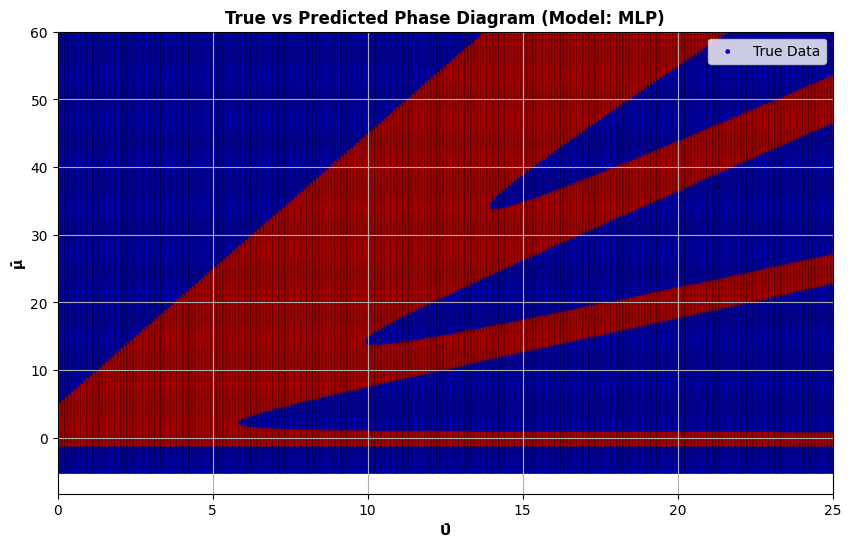

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [10]:
    # ---------- 7) True vs Predicted (overlay comparison) ----------
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(df["Ubar"], df["Mubar"], c=df["Phase"], s=10,
                cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2, label="True Data")
    plt.xlabel("Ū", fontsize=10, fontweight="bold")
    plt.ylabel("μ̄", fontsize=10, fontweight="bold")
    plt.title(f"True vs Predicted Phase Diagram (Model: {i})", fontsize=12, fontweight="bold")
    plt.legend(loc="upper right", frameon=True)
    plt.grid(True)
    plt.show()

    # ---------- 8) Error Map (highlight mismatches) ----------
    error_mask = np.full_like(phase_map, np.nan, dtype=float)

    # mark where prediction != truth inside known data domain
    for idx, row in grid_in_domain[valid].iterrows():
        U_idx = int(round((row["Ubar"] - U_min) / U_step))
        mu_idx = int(round((row["Mubar"] - mu_min) / mu_step))
        if 0 <= U_idx < error_mask.shape[1] and 0 <= mu_idx < error_mask.shape[0]:
            error_mask[mu_idx, U_idx] = float(pred_labels[valid.index(idx)] != true_labels[valid.index(idx)])

    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, error_mask, levels=[-0.5, 0.5, 1.5],
                 colors=["white", "red"], alpha=0.6)
    plt.xlabel("Ū", fontsize=10, fontweight="bold")
    plt.ylabel("μ̄", fontsize=10, fontweight="bold")
    plt.title(f"Prediction Error Map (Model: {i})", fontsize=12, fontweight="bold")
    plt.colorbar(label="Error (1 = mismatch)")
    plt.grid(True)
    plt.show()


In [8]:
# ---------- 8) Error Map (where prediction ≠ ground truth) ----------

# Create a difference mask
error_mask = np.full_like(phase_map, np.nan, dtype=float)

# Map valid points to grid indices
for idx, row in grid_in_domain[valid].iterrows():
    U_idx = int(round((row["Ubar"] - U_min) / U_step))
    mu_idx = int(round((row["Mubar"] - mu_min) / mu_step))
    if 0 <= U_idx < error_mask.shape[1] and 0 <= mu_idx < error_mask.shape[0]:
        error_mask[mu_idx, U_idx] = float(pred_labels[valid.index(idx)] != true_labels[valid.index(idx)])

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, error_mask, levels=[-0.5, 0.5, 1.5],
             colors=["white", "red"], alpha=0.6)
plt.xlabel("Ū", fontsize=10, fontweight="bold")
plt.ylabel("μ̄", fontsize=10, fontweight="bold")
plt.title(f"Prediction Error Map (Model: {i})", fontsize=12, fontweight="bold")
plt.colorbar(label="Error (1 = mismatch)")
plt.grid(True)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'index'